In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Підготовка та тренування моделі

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [5]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [7]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 23s 9ms/step - loss: 0.1474 - accuracy: 0.9543 - val_loss: 0.0483 - val_accuracy: 0.9854
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0455 - accuracy: 0.9860 - val_loss: 0.0350 - val_accuracy: 0.9899
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 0.0372 - val_accuracy: 0.9882
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0352 - val_accuracy: 0.9886
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0261 - val_accuracy: 0.9922
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.0348 - val_accuracy: 0.9900
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0524 - val_accuracy

In [8]:
def plot_metric(train_data, test_data, label):
    plt.plot(train_data, label=f'train {label}')
    plt.plot(test_data, label=f'test {label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()

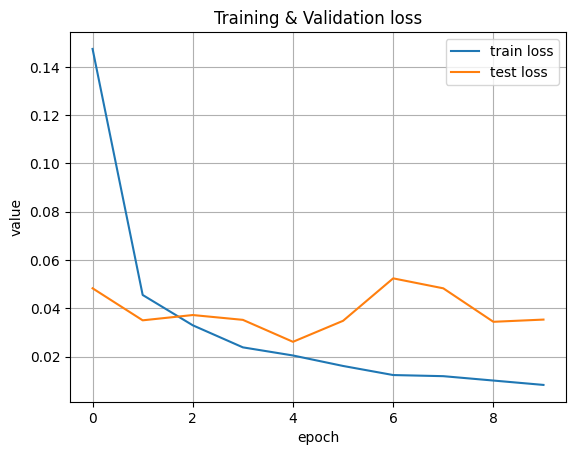

In [9]:
plot_metric(history.history['loss'], history.history['val_loss'], 'loss')

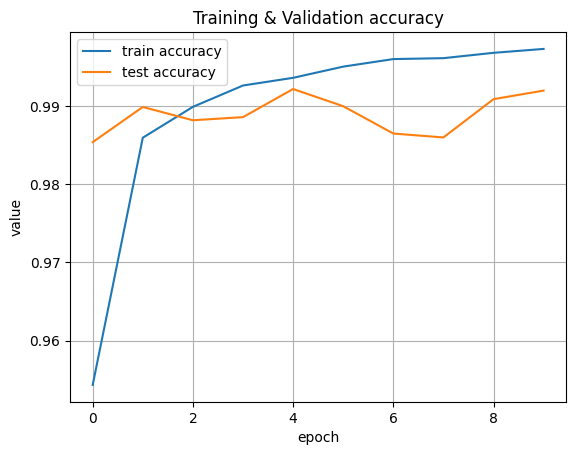

In [10]:
plot_metric(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

### Реалізація граф-дороги

In [11]:
n = 40
indices = np.where((y_test != 0) & (y_test != 1))[0]
indices = np.random.choice(indices, n, replace=False)

In [12]:
rand_images = list(x_test[indices])
rand_labels = list(y_test[indices])

In [13]:
class Graph:
    def __init__(self, vertices=25, edges_to_remove=10):
        self.vertices = vertices
        self.width = int(vertices ** 0.5)
        self.structure = {i: [] for i in range(vertices)}
        self._form_structure()
        self._remove_edges(edges_to_remove)
        self._coords = {}
        self._calc_coords()
        self.edges = {}
        self._set_speed_limits(rand_images, rand_labels)

    def _form_structure(self):
        for i in range(self.vertices-1):
            if (i+1) % self.width != 0:
                self.structure[i].append(i+1)
                self.structure[i+1].append(i)
            if i < (self.vertices - self.width):
                self.structure[i].append(i+self.width)
                self.structure[i+self.width].append(i)

    def _calc_coords(self):
        for i in range(self.width):
            for t in range(self.width):
                self._coords[t+(i*5)] = [i, t]

    def _add_edge(self, v1, v2):
        self.structure[v1].append(v2)
        self.structure[v2].append(v1)

    def _delete_edge(self, v1, v2):
        self.structure[v1].remove(v2)
        self.structure[v2].remove(v1)

    def _is_connected(self):
        not_visited = [i for i in range(self.vertices)]
        queue = [0]

        while queue:
            s = queue.pop(0)
            for neighbor in self.structure[s]:
                if neighbor in not_visited:
                    not_visited.remove(neighbor)
                    queue.append(neighbor)

        return not bool(not_visited)

    def _remove_edges(self, count):
        i = 0
        while i < count:
            vertex = random.randint(0, len(self.structure)-1)
            if len(self.structure[vertex])-1 == 0:
                continue
            neighbor = random.randint(0, len(self.structure[vertex])-1)
            neighbor = self.structure[vertex][neighbor]

            self._delete_edge(vertex, neighbor)
            if not self._is_connected():
                self._add_edge(vertex, neighbor)
            else:
                i += 1

    def _set_speed_limits(self, images, labels):
        cimages, clabels = images.copy(), labels.copy()
        for key, value in self.structure.items():
            for i in value:
                if ((key, i) not in self.edges) and \
                   ((i, key) not in self.edges):
                    self.edges[(key, i)] = [cimages.pop(), clabels.pop()]

    def get_neighs(self, vert):
        a = {}
        for i in self.structure[vert]:
            a[i] = self._coords[i]
        return a

    def get_coords(self, vertex):
        return self._coords[vertex]

### Реалізація агента

In [14]:
def best_route(agent, routes, best=float('inf'), vert=None, parent=None):
    for route in routes:
        if (route not in agent.hist) and (route != agent.pos):
            x, y = agent.road.get_coords(route)
            dist = abs(x - agent.des_crds[0]) + abs(y - agent.des_crds[1])
            if dist < best:
                best = dist
                vert = parent if (parent is not None) else route

            if isinstance(routes, dict):
                best, vert = best_route(agent, routes[route], best, vert, route)

    return best, vert

In [15]:
class Agent():
    def __init__(self, pos, des, road):
        self.pos = pos
        self.des = des
        self.des_crds = road.get_coords(des)
        self.road = road
        self.routes = {}
        self.hist = []
        self.map = []
        self.speed_hist = []

    def _tell(self):
        neighs = self.road.get_neighs(self.pos)
        self.routes = {}
        for i in neighs:
            self.routes[i] = list(self.road.get_neighs(i).keys())

    def _ask(self):
        _, vert = best_route(self, self.routes)
        return vert

    def _do(self, vert):
        if vert is None:
            vert = self.map[-1]
            self.map.pop()
        else:
            self.map.append(self.pos)

        if (self.pos, vert) in self.road.edges:
            speed_sign = self.road.edges[(self.pos, vert)][0]
        else:
            speed_sign = self.road.edges[(vert, self.pos)][0]
        speed = np.argmax(model.predict(speed_sign.reshape(1, 28, 28, 1), verbose=False))

        self.speed_hist.append(speed)
        self.hist.append(self.pos)
        self.pos = vert

    def move(self):
        while self.pos != self.des:
            self._tell()
            vert = self._ask()
            self._do(vert)
        self.hist.append(self.pos)

### Функції для графічного відображення граф-дороги та шляху агента

In [16]:
def draw_graph(graph):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')

    coords = []
    for i in range(graph.width):
        for t in range(graph.width):
            coords.append([(i+1)*50,(t+1)*50])
            circle = Circle(((i+1)*50, (t+1)*50), 8, fill=True, color='black')
            ax.add_patch(circle)
            ax.text((i+1)*50, (t+1)*50, t+(i*5),
                    fontsize=10, color='white', ha='center', va='center')

    for i in graph.structure:
        for t in graph.structure[i]:
            line = Line2D([coords[i][0], coords[t][0]],
                          [coords[i][1], coords[t][1]],
                          color='black', linewidth=1)
            ax.add_line(line)

            if (i, t) not in graph.edges:
                continue
            value = graph.edges[(i, t)][1]
            if coords[i][0] == coords[t][0]:
                y_crd = coords[i][1] + (coords[t][1] - coords[i][1]) / 2
                ax.text(coords[i][0]+5, y_crd, f'{value}',
                        fontsize=10, color='blue', ha='center', va='center')
            elif coords[i][1] == coords[t][1]:
                x_crd = coords[i][0] + (coords[t][0] - coords[i][0]) / 2
                ax.text(x_crd, coords[i][1]+5, f'{value}',
                        fontsize=10, color='blue', ha='center', va='center')

    ax.plot()
    ax.axis('off')
    plt.show()

    return coords

In [17]:
def draw_agent(agent, coords):
    print('Initial vertex:', agent.hist[0])
    print('Final vertex:', agent.hist[-1])
    print('Steps:', len(agent.hist)-1)
    print('Way:', end=' ')
    for i in agent.hist:
        print(i, end=f'{"" if i == agent.hist[-1] else " -> "}')
    print('\nSpeed limits:', end=' ')
    for i in agent.speed_hist:
        print(f'{i}0km/h', end='  ')
    print('\n')

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')

    pairs = [(agent.hist[i], agent.hist[i+1]) for i in range(len(agent.hist)-1)]
    pairs.append((agent.des, agent.des))

    i = 0
    for a, b in pairs:
        line = Line2D([coords[a][0], coords[b][0]],
                        [coords[a][1], coords[b][1]], color='black', linewidth=1)
        ax.add_line(line)
        x, y = coords[a]
        circle = Circle((x, y), 8, fill=True, color='black')
        ax.add_patch(circle)
        ax.text(x, y, a, fontsize=10, color='white', ha='center', va='center')

        if a == b:
            continue
        if coords[a][0] == coords[b][0]:
            y_crd = coords[a][1] + (coords[b][1] - coords[a][1]) / 2
            ax.text(coords[a][0]+5, y_crd, f'{agent.speed_hist[i]}',
                    fontsize=10, color='blue', ha='center', va='center')
        elif coords[a][1] == coords[b][1]:
            x_crd = coords[a][0] + (coords[b][0] - coords[a][0]) / 2
            ax.text(x_crd, coords[a][1]+5, f'{agent.speed_hist[i]}',
                    fontsize=10, color='blue', ha='center', va='center')
        i += 1

    ax.plot()
    ax.axis('off')
    plt.show()

### Тестування роботи

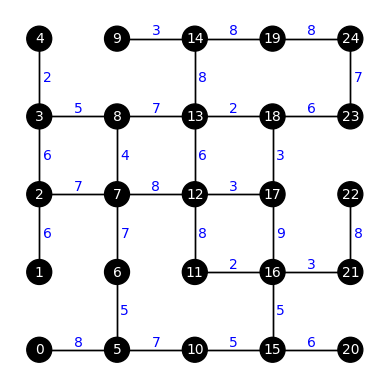

In [18]:
graph = Graph()
crds = draw_graph(graph)

Initial vertex: 0
Final vertex: 24
Steps: 8
Way: 0 -> 5 -> 6 -> 7 -> 8 -> 13 -> 14 -> 19 -> 24
Speed limits: 80km/h  50km/h  70km/h  40km/h  70km/h  80km/h  80km/h  80km/h  



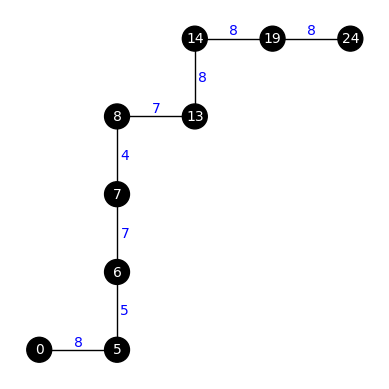

In [19]:
rand = False
a = random.randint(0, 24) if rand else 0
b = random.randint(0, 24) if rand else 24

agent = Agent(a, b, graph)
agent.move()

draw_agent(agent, crds)

#### Висновок
Під час виконання лабораторної роботи я отримав практичні навички роботи з нейронними мережами та вирішення проблеми класифікації зображень шляхом удосконалення інтелектуального агента-автомобіля з попередніх робіт, додавши йому систему контролю швидкості на основі згорткової нейронної мережі